Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses RandomForest to predict Churn, and GridSearchCV to perform hyperparameter tuning.   

**Note:**
- All date range.
- registered_only = True

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/RandomForest/Churn_RandomForest_All_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 1, 1)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2000, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = True
mlflow.log_param("Setup complete", registered_only)

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

all companies with licenses: 13417

In [0]:
df['InstanceId'].value_counts()

Out[78]: 50 3281
53 821
Name: InstanceId, dtype: int64

In [0]:
mlflow.log_param("Instances", df['InstanceId'].value_counts())

billable companies join with licenses: 4102

Out[75]: (4102, 24)

Out[76]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
0,822,50,None,10,True,0,694,Ward Alternative Energy,Fort Collins,Colorado,80521,US,en-US,2016-01-21,None,2020-09-19 00:00:44.750,1441,0,9,0,2819,0,66,0
1,872,50,None,30,True,0,744,TECS ELECTRIC LTD,Weatherford,TX,76087,US,en-US,2016-01-27,None,NaT,1435,0,43,0,0,5,4,521
2,965,53,None,10,True,0,21488,Southwest Center,Louisville,KY,40258,US,en-US,2018-02-26,None,NaT,674,0,17,7,16293,1,0,0
3,1027,50,None,10,True,0,899,Hood River Taxi,Hood River,Oregon,97031,US,en-US,2016-02-12,None,2016-09-10 13:06:52.400,211,1,8,0,922,0,0,0
4,1107,50,None,10,True,0,979,AAA Signs Inc,Sacramento,California,95815,US,en-US,2016-03-04,None,2017-12-21 00:13:54.140,657,1,34,0,16683,2,0,6


In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]
if registered_only:
  categorical_features = ["Tier", "UserIntegrationType"]

Categorical feature distributions

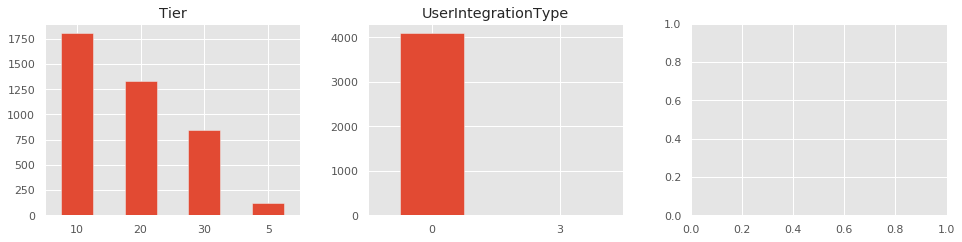

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

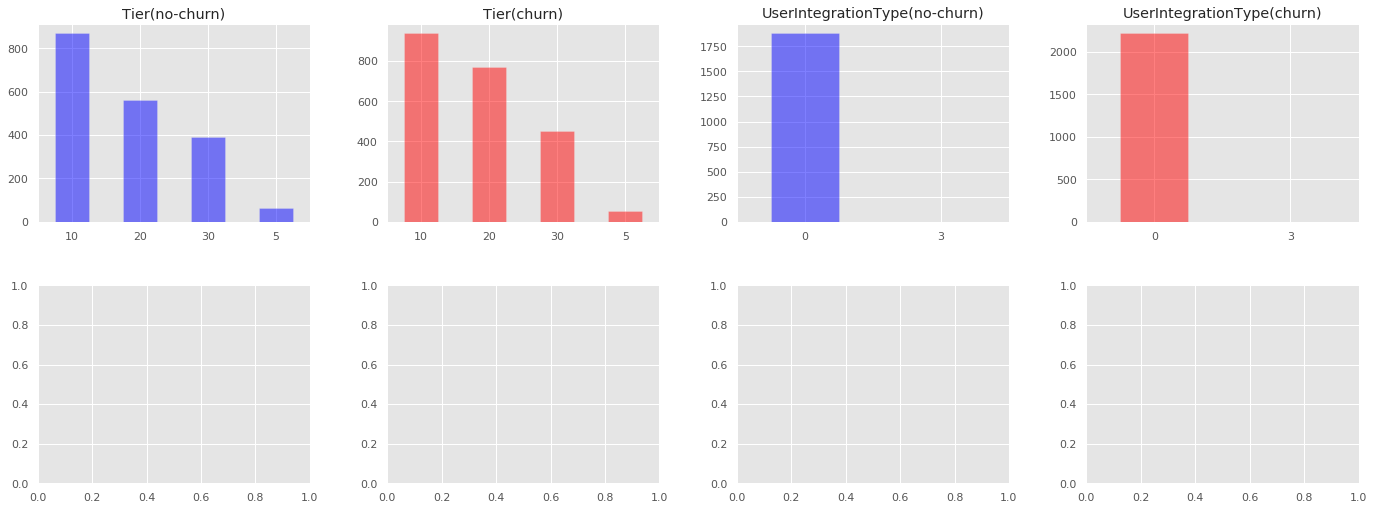

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('UserIntegrationType(churn)')

if registered_only == False:
  df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('IsSetupComplete(no-churn)')
  df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('IsSetupComplete(churn)')
  
fig.tight_layout(pad=4.0)


Numerical feature distributions

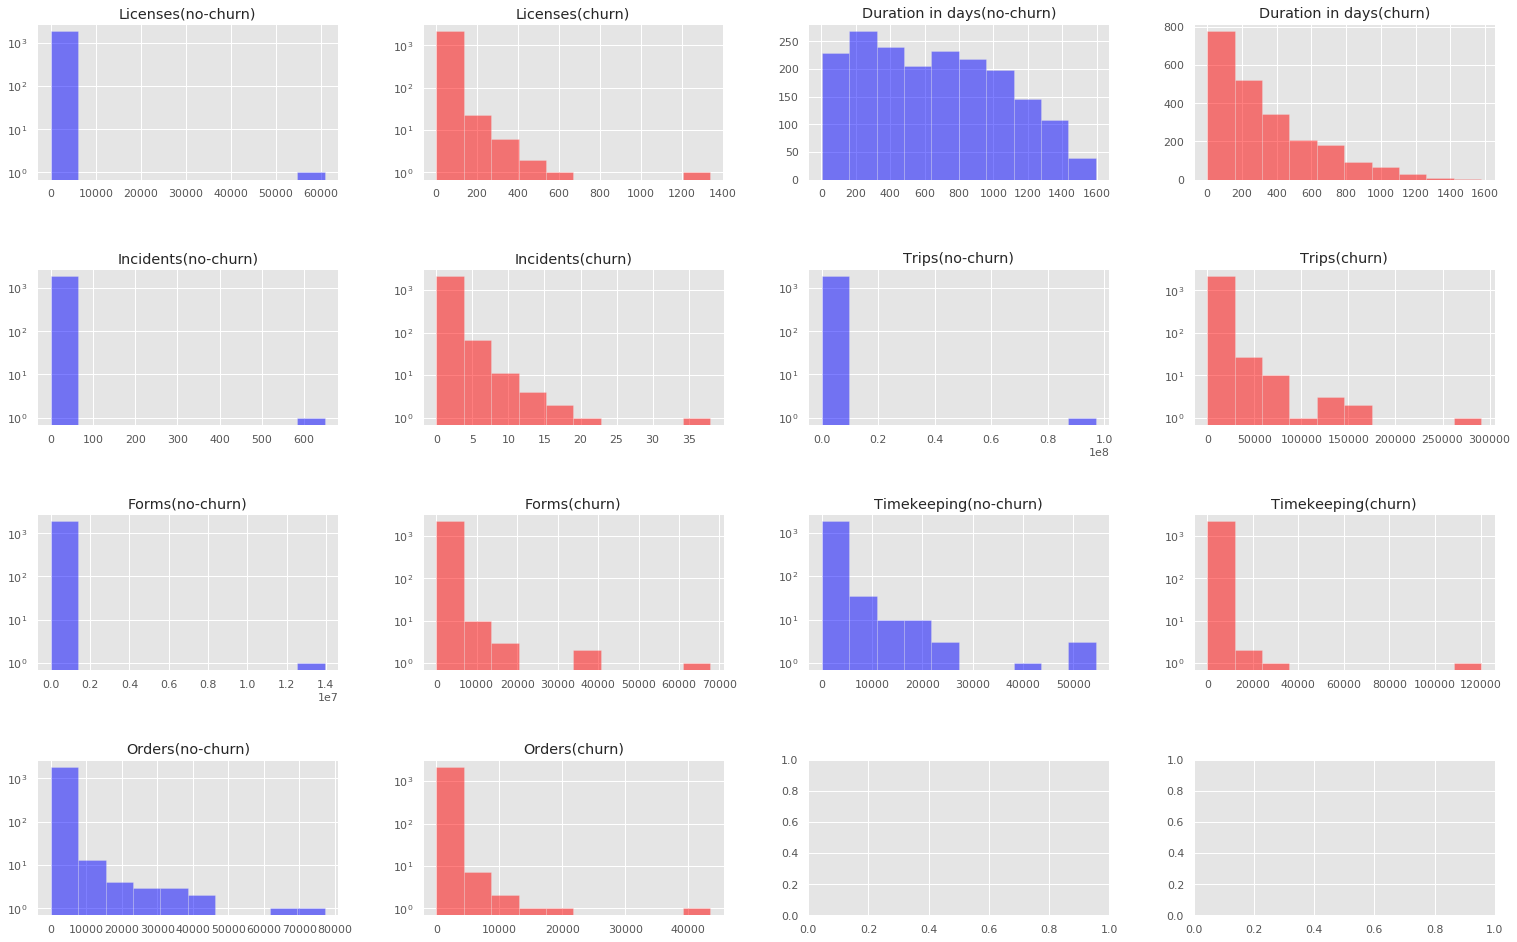

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

Correlation Matrix and Heatmap

In [0]:
df_corr = df[categorical_features + [target] + numerical_features]

df_corr.corr()

Out[84]:

,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
Tier,1.000000,-0.020018,0.030242,-0.014002,0.005116,-0.003796,-0.014767,-0.010614,0.086202,0.110008
UserIntegrationType,-0.020018,1.000000,-0.001826,0.005332,0.030986,-0.002677,-0.000487,-0.000442,-0.002983,-0.002359
Churn,0.030242,-0.001826,1.000000,-0.032584,-0.422801,-0.074870,-0.021854,-0.020675,-0.071779,-0.077581
Licenses,-0.014002,0.005332,-0.032584,1.000000,0.037847,0.968066,0.995813,0.994707,0.018802,0.005280
Duration,0.005116,0.030986,-0.422801,0.037847,1.000000,0.068076,0.029195,0.028697,0.103458,0.110937
Incidents,-0.003796,-0.002677,-0.074870,0.968066,0.068076,1.000000,0.967435,0.966868,0.037338,0.038852
Trips,-0.014767,-0.000487,-0.021854,0.995813,0.029195,0.967435,1.000000,0.998993,0.008464,0.001478
Forms,-0.010614,-0.000442,-0.020675,0.994707,0.028697,0.966868,0.998993,1.000000,0.009308,0.001911
Timekeeping,0.086202,-0.002983,-0.071779,0.018802,0.103458,0.037338,0.008464,0.009308,1.000000,0.107996
Orders,0.110008,-0.002359,-0.077581,0.005280,0.110937,0.038852,0.001478,0.001911,0.107996,1.000000


Out[85]:

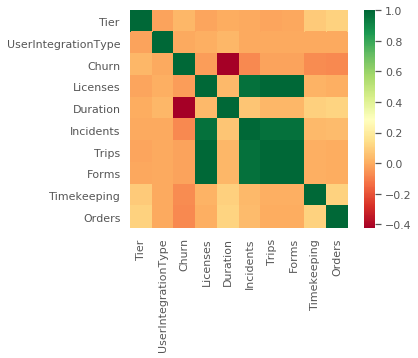

<matplotlib.axes._subplots.AxesSubplot at 0x7f938aa0a750>

In [0]:
plt.style.use('ggplot')

sns.heatmap(df_corr.corr(), square=True, cmap='RdYlGn')

In [0]:
df_corr.describe(include='all')

Out[86]:

,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
count,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4.102000e+03,4.102000e+03,4102.000000,4102.000000
mean,17.219649,0.001463,0.541199,49.195758,482.533886,1.268893,3.340742e+04,4.361554e+03,403.130912,273.235982
std,7.966418,0.066235,0.498360,954.065487,378.863793,10.469011,1.514240e+06,2.179420e+05,2985.049515,2558.567155
min,5.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,10.000000,0.000000,0.000000,6.000000,163.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,20.000000,0.000000,1.000000,13.000000,383.000000,0.000000,1.680000e+02,0.000000e+00,0.000000,0.000000
75%,20.000000,0.000000,1.000000,29.000000,738.500000,1.000000,5.286000e+03,4.000000e+00,5.000000,0.000000
max,30.000000,3.000000,1.000000,60810.000000,1595.000000,649.000000,9.692331e+07,1.394515e+07,120322.000000,77193.000000


Sampled dataframe

In [0]:
df_sampled = df.sample(replace=False, frac=1, random_state=42)

df_sampled.shape

Out[87]: (4102, 24)

**Training**

In [0]:
df_final = df_sampled[categorical_features + [target] + numerical_features]

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

In [0]:
# training the model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(random_state=42)

# Setup the parameters and distributions to sample from: param_grid
# Parameter selections are based on the previous tuning.
# param_grid = {'classifier__max_depth': [3,4,5,6,7,8,None], 
#               'classifier__min_samples_leaf': np.arange(1, 5), 
#               'classifier__min_samples_split': np.arange(2, 5),
#               'classifier__class_weight': ['balanced', 'balanced_subsample', None],
#               'classifier__bootstrap': [False, True]
#              }

param_grid = {'max_depth': np.linspace(10, 30, 10, dtype=np.int32),
              'min_samples_leaf': np.arange(1, 5), 
              'min_samples_split': np.arange(2, 5),
              'class_weight': ['balanced'],
              'bootstrap': [True],
              'n_estimators': [60,70,80,90,100]
             }

tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

tree_cv.fit(X_train, np.ravel(y_train))

pred = tree_cv.predict(X_test)

print("Tuned RandomForest: {}".format(tree_cv.best_params_))
print('Accuracy of RandomForest classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", tree_cv.best_params_)
mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))


Tuned RandomForest: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 80}
Accuracy of RandomForest classifier on test set: 0.75

Log the model to the registry for deployment

In [0]:
# sklearn model wrapper
class ModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

wrappedModel = ModelWrapper(tree_cv.best_estimator_)
mlflow.pyfunc.log_model("RandomForest_model", python_model=wrappedModel)

**Testing **

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.73 0.73 0.73 490
 1 0.76 0.76 0.76 536

 accuracy 0.75 1026
 macro avg 0.75 0.75 0.75 1026
weighted avg 0.75 0.75 0.75 1026

In [0]:
report = classification_report(y_test, pred, output_dict=True)
# an easy workaround to log dictionary (nested) since log_metric doesn't support it.
mlflow.log_params(report)

In [0]:
condition = (pred < 1)
noChurn = np.extract(condition, pred) 
print(noChurn)

condition = (pred > 0)
churn = np.extract(condition, pred) 
print(churn)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Get model, class names & feature names

In [0]:
model = tree_cv.best_estimator_
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print("Number of trees: {}".format(len(model)))
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

Number of trees: 80
Feature names: ['Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

**Model Interpretation**

In [0]:
import shap

plt.style.use('ggplot')

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

print(len(shap_values[0]))
print(shap_values[0][0])

3076
[-0.01645162 0. -0.01584454 -0.13376479 -0.02873301 -0.10628789
 -0.02981937 0.00699419 -0.00056993]

Summy plot: impact on mdoel output for **Churn and No-Churn**

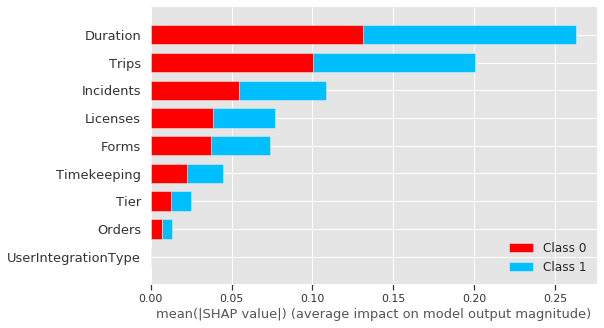

In [0]:
RGB_val = 255
blue = (0/RGB_val, 191/RGB_val, 255/RGB_val)
red= (255/RGB_val, 0/RGB_val, 0/RGB_val)
colors = [red, blue]
cmap = mpl.colors.ListedColormap(colors, name="CustomColors")

shap.summary_plot(shap_values, X_train, plot_type="bar", color=cmap)

Summary plot for **No-Churn**

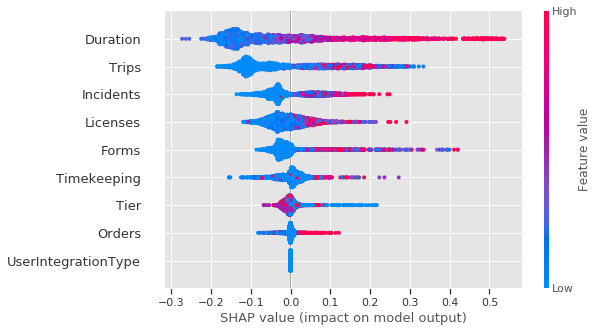

In [0]:
shap.summary_plot(shap_values[0], X_train)

Summary plot for **Churn**

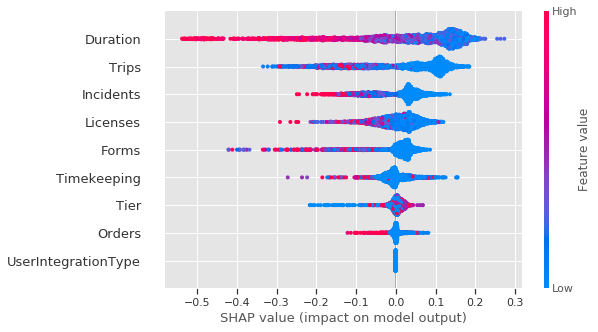

In [0]:
shap.summary_plot(shap_values[1], X_train)

Dependence plot for **Duration (No-Churn)**

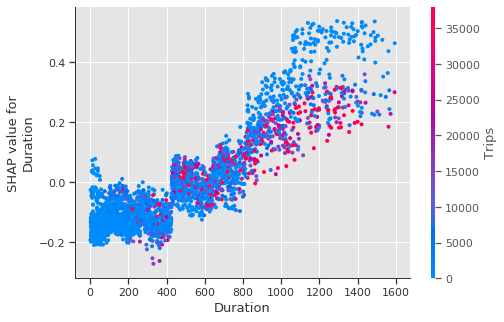

In [0]:
shap.dependence_plot('Duration', shap_values[0], X_train)

Dependence plot for **Duration (Churn)**

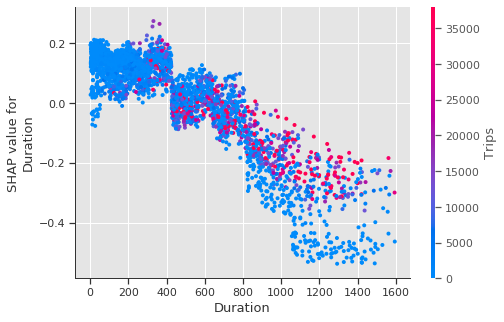

In [0]:
shap.dependence_plot('Duration', shap_values[1], X_train)

Decision plots for **Churn**

In [0]:
# get churn test data
y_churned = y_test[y_test.Churn == True]
X_churned = X_test.loc[y_churned.index]

# create predict pd with same index as y_test
y_pred = pd.DataFrame(data=pred,index=y_test.index)

# expected values
expected_value = explainer.expected_value
print(expected_value)

[0.5014332 0.4985668]

In [0]:
# we just pick 1 churn to display
X_display = X_churned.iloc[[0]]
df_sampled.loc[X_display.index]

Out[102]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
4076,10680,50,None,10,True,0,8576,Fallbrook Rib Shack,None,None,None,US,en-US,2017-11-18,2018-10-02,2018-10-02 00:12:25.250,318,1,2,0,13,0,0,0


In [0]:
# this is the predicted value compared to the acutal above.
y_pred.loc[X_display.index]

Out[103]:

,0
4076,1


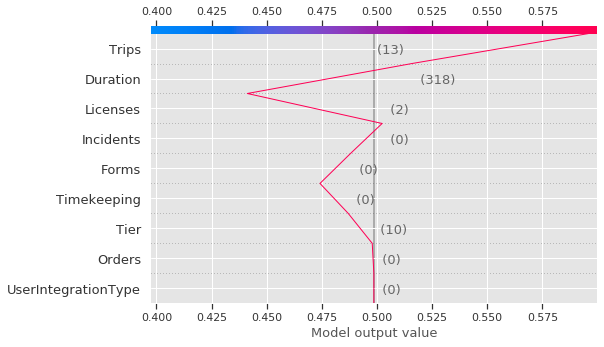

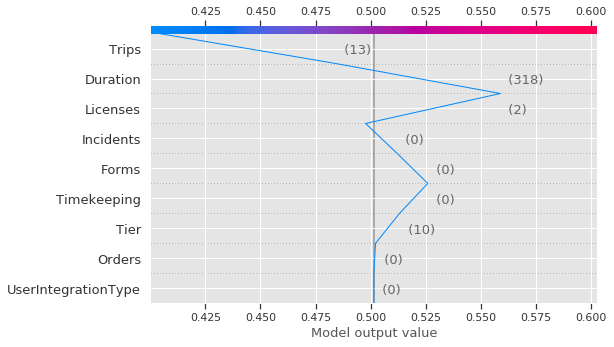

In [0]:
# Red is for class 1 (Churn)
shap_values_display = explainer.shap_values(X_display)
shap.decision_plot(expected_value[1], shap_values_display[1], X_display)

# Blue is for class 0 (No Churn)
shap_values_display = explainer.shap_values(X_display)
shap.decision_plot(expected_value[0], shap_values_display[0], X_display)

The above company has **Churn value > No-Churn. It is Churned!**   
Notes: This company shows Chance of churn > no-churn. As a comparison, you will see in the later cases that chance of no-churn is zero in terms of SHAP values.

In [0]:
X_display = X_churned.iloc[[1]]
df_sampled.loc[X_display.index]

Out[105]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
1525,2377,50,None,20,True,0,2238,Dirigo Management,Portland,Maine,04101,US,en-US,2016-07-06,None,2016-12-18 00:13:53.700,165,1,7,0,16,5,8,32


In [0]:
# this is the predicted value compared to the acutal above.
y_pred.loc[X_display.index]

Out[106]:

,0
1525,1


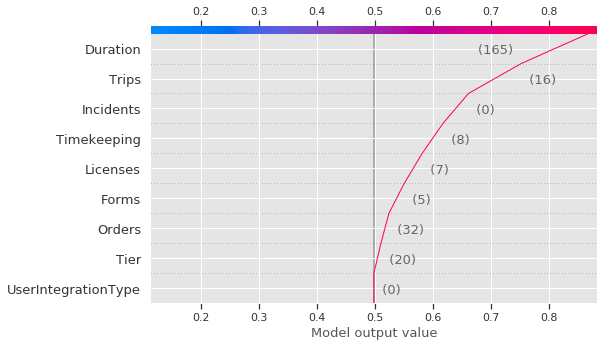

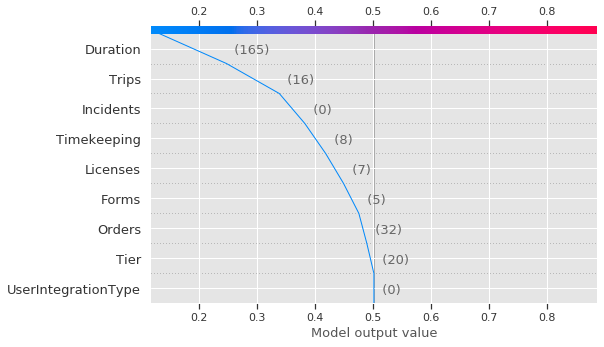

In [0]:
shap_values_display = explainer.shap_values(X_display)
shap.decision_plot(expected_value[1], shap_values_display[1], X_display)

shap_values_display = explainer.shap_values(X_display)
shap.decision_plot(expected_value[0], shap_values_display[0], X_display)

The above company has **Churn value > No-Churn. It is Churned!**

In [0]:
X_display = X_churned.iloc[[2]]
df_sampled.loc[X_display.index]

Out[108]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
2106,2615,50,None,30,True,0,2476,Heirloom Builders LLC,Gloucester,Massachusetts,01930,US,en-US,2016-07-23,None,2017-04-30 00:03:36.200,281,1,17,0,0,38,801,2


In [0]:
# this is the predicted value compared to the acutal above.
y_pred.loc[X_display.index]

Out[109]:

,0
2106,0


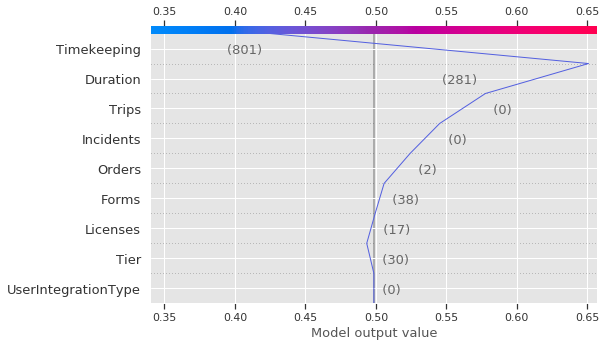

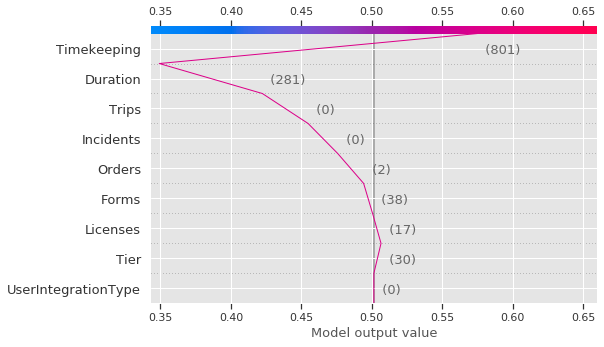

In [0]:
shap_values_display = explainer.shap_values(X_display)
shap.decision_plot(expected_value[1], shap_values_display[1], X_display)

shap_values_display = explainer.shap_values(X_display)
shap.decision_plot(expected_value[0], shap_values_display[0], X_display)

The above company has **Churn value > No-Churn. It is Churned!**

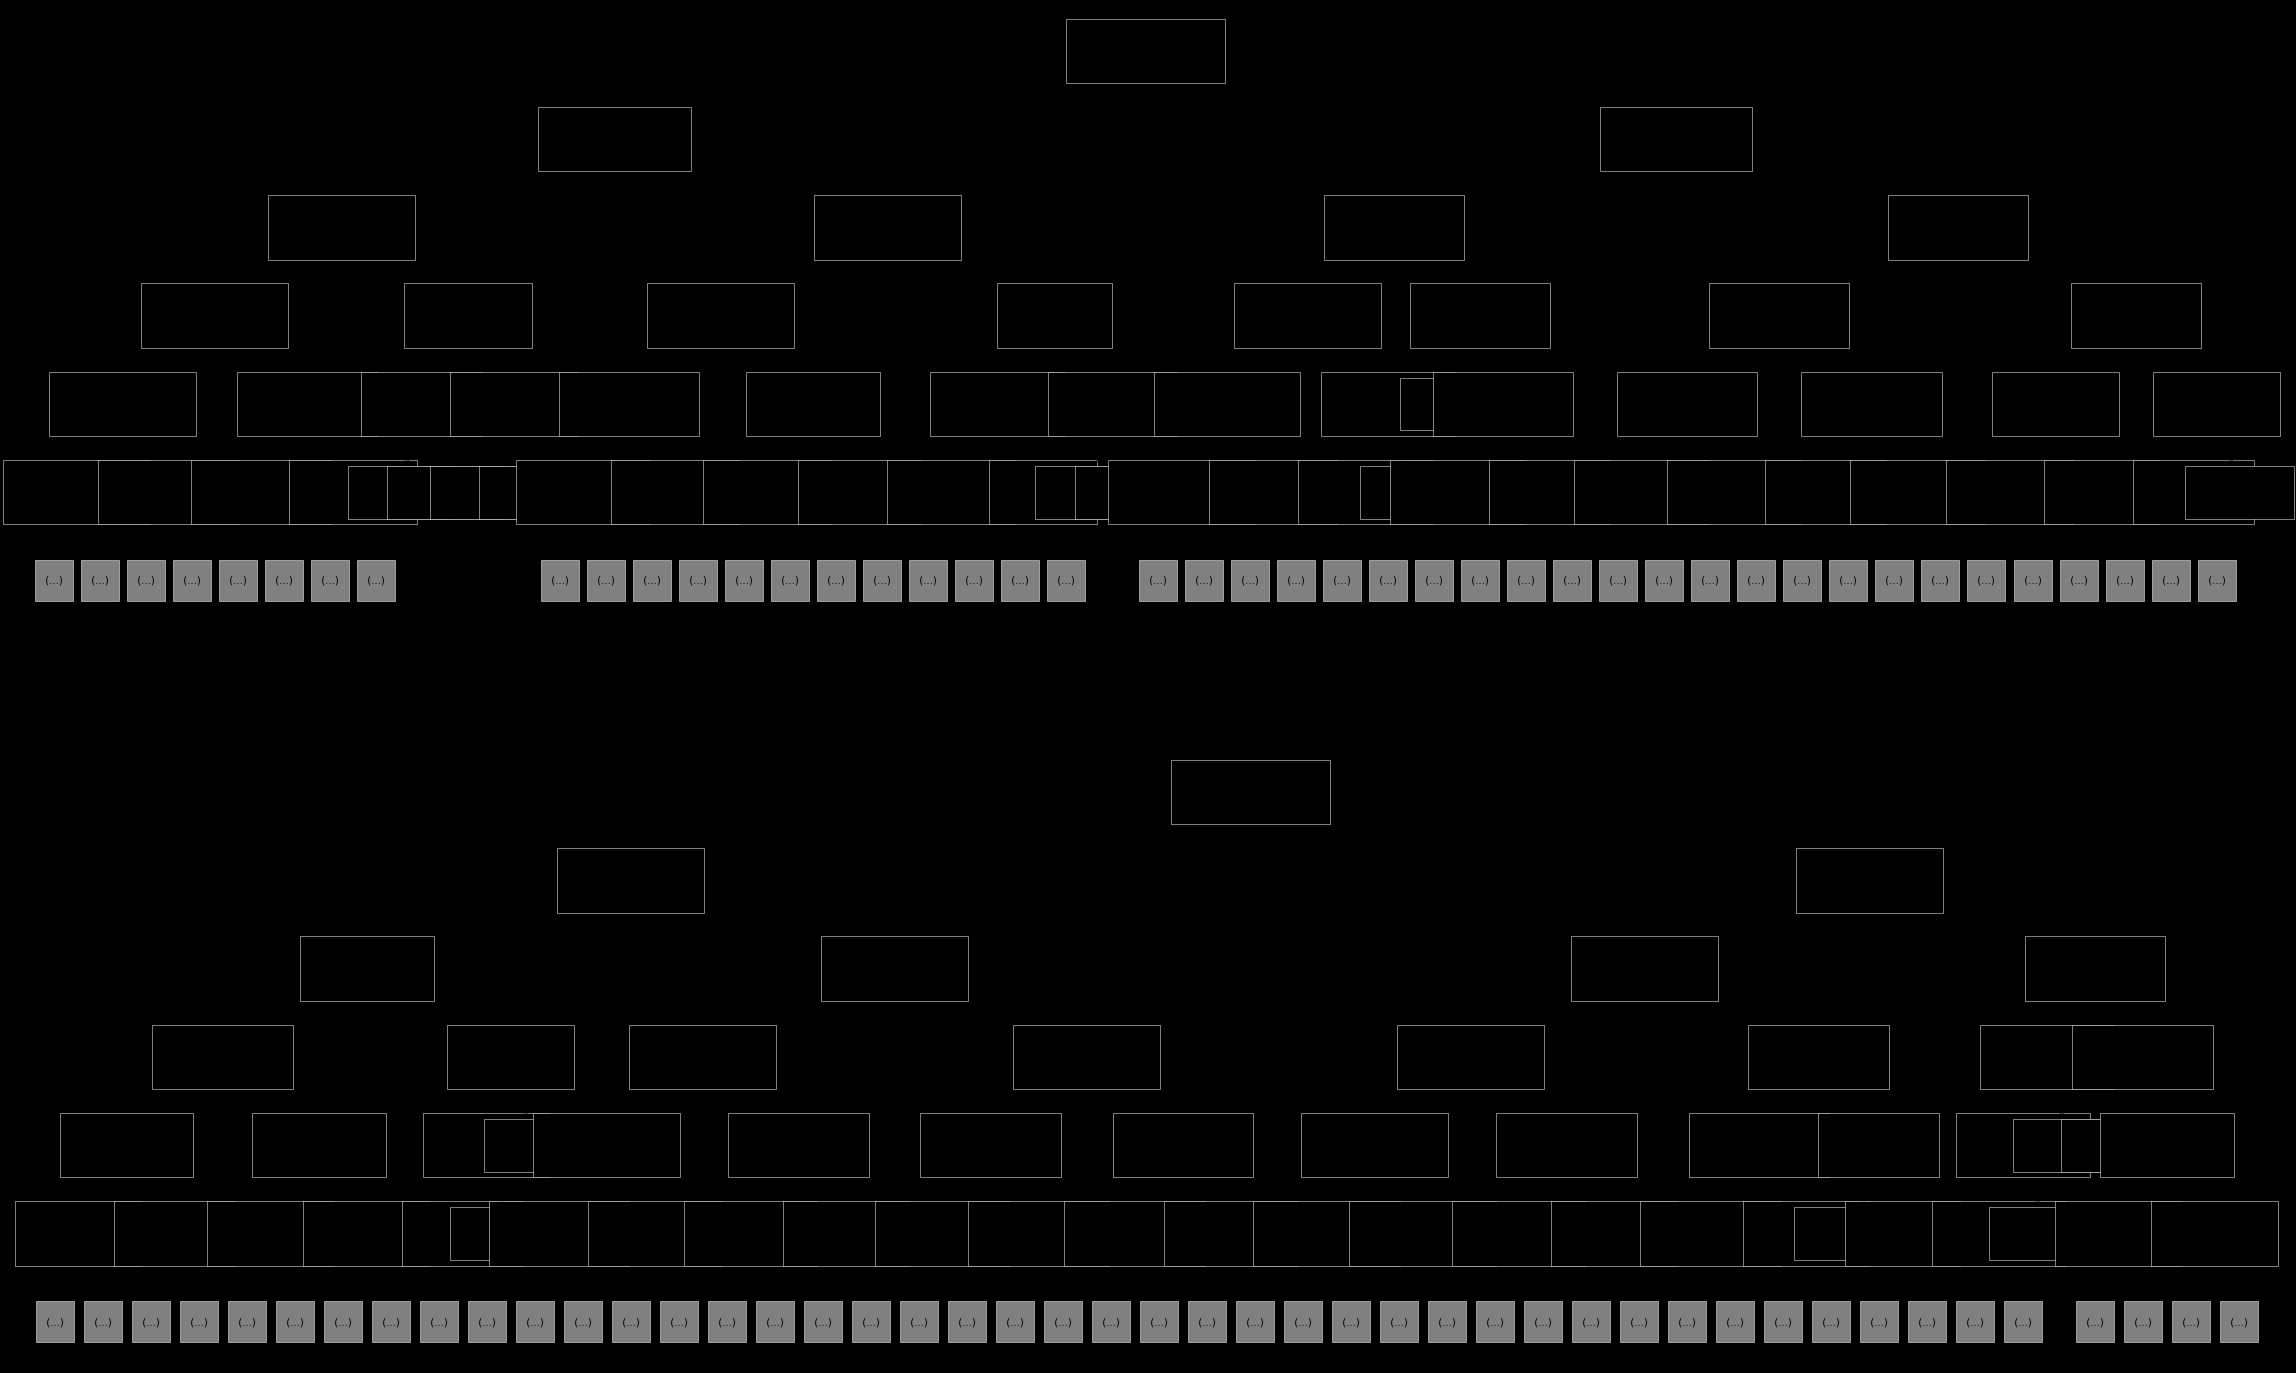

In [0]:
from sklearn import tree

plt.style.use('dark_background')
mpl.rcParams['text.color'] = 'black'

fig, ax = plt.subplots(2, figsize=(40, 25))

tree.plot_tree(decision_tree = model[0],
               feature_names = feature_names, 
               class_names = class_names,
               fontsize = 10,
               proportion = False,
               rounded = False,
               max_depth = 5,
               ax = ax[0])

tree.plot_tree(decision_tree = model[1],
               feature_names = feature_names, 
               class_names = class_names,
               fontsize = 10,
               proportion = False,
               rounded = False,
               max_depth = 5,
               ax = ax[1])

plt.show()

ROC Curve for test data

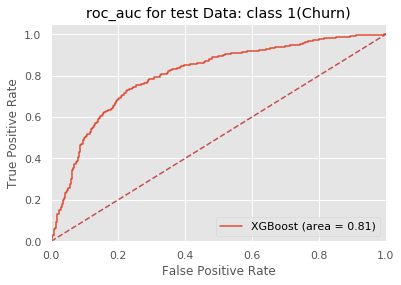

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.style.use('ggplot')

tree_roc_auc = roc_auc_score(y_test, tree_cv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree_cv.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 test data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_auc for test Data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

ROC Curve for train data

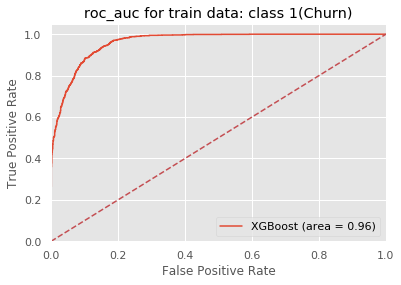

In [0]:
tree_roc_auc = roc_auc_score(y_train, tree_cv.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, tree_cv.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 train data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_auc for train data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [0]:
mlflow.end_run()